# Combining satellite data with tidal modelling <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Description


***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import sys

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_coastaltools import tidal_tag

%load_ext autoreload
%autoreload 2

### Connect to the datacube


In [2]:
# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc = datacube.Datacube(app='Tidal_modelling', env='c3-samples')
except:
    dc = datacube.Datacube(app='Tidal_modelling')


## Loading multiple Landsat sensors
The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple `DEA` products or satellite sensors. 
At its simplest, you can use the function similarly to `dc.load` by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the dc.load documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that `load_ard` also requires an existing `Datacube` object, which is passed using the `dc` parameter. 
This gives us the flexibilty to load data from development or experimental datacubes.

In the examples below, we load a single band of data (`nbart_green`) from the three Landsat Collection 3 products (Landsat 5, 7 and 8) by specifying: `products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']`.
The function always outputs the number of observations for each product, and the total number loaded.
For the following examples, the function output shows that 0 Landsat 5 observations, 11 Landsat 7 observations, and 12 Landsat 8 observations were loaded, for a combined total of 23 observations.

### Explicit syntax
The following example demonstrates how key parameters can be passed directly to `load_ard`.

In [87]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              x=(117.790868, 117.800868),
              y=(-20.489549, -20.499549),
              time=('1988', '2018'),
              measurements=['nbart_green'],
              output_crs='EPSG:32751',
              resolution=(-30, 30),
              group_by='solar_day',
              dask_chunks={})

# Print output data
print(ds)



Loading ga_ls5t_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls7e_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 868 observations as a dask array
<xarray.Dataset>
Dimensions:      (time: 868, x: 37, y: 39)
Coordinates:
  * y            (y) float64 7.726e+06 7.726e+06 ... 7.725e+06 7.725e+06
  * x            (x) float64 -4.376e+04 -4.372e+04 ... -4.270e+04 -4.268e+04
  * time         (time) datetime64[ns] 1988-01-10T01:37:25.304249 ... 2018-12-30T02:08:19.697351
Data variables:
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 39, 37), meta=np.ndarray>
Attributes:
    crs:      EPSG:32751


''

### Modelling tide heights


In [88]:
import numpy as np
import pandas as pd
from otps import TimePoint
from otps import predict_tide
import matplotlib.pyplot as plt
from datacube.utils.geometry import CRS

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [89]:
def tidal_eval(ds, 
               tidepost_lat=None,
               tidepost_lon=None,
               plain_english=True, 
               plot=True,
               round_stats=2): 
    """
    Takes an xarray.Dataset and statistically compares the tides modelled 
    for each satellite observation against the full modelled tidal range.
    This comparison can be used to evaluate whether the tides observed by
    satellites (e.g. Landsat) are biased compared to the natural tidal range 
    (e.g. fail to observe either the highest or lowest tides etc).    
       
    By default, the function models tides for the centroid of the 
    dataset, but a custom tidal modelling location can be specified 
    using `tidepost_lat` and `tidepost_lon`.
    
    Tides are modelled using the OTPS tidal modelling software based on
    the TPXO8 tidal model: http://volkov.oce.orst.edu/tides/tpxo8_atlas.html
    
    For more information about the tidal statistics computed by this function,
    refer to Figure 8 in Bishop-Taylor et al. 2018:
    https://www.sciencedirect.com/science/article/pii/S0272771418308783#fig8
    
    Parameters
    ----------     
    ds : xarray.Dataset
        An xarray.Dataset object with x, y and time dimensions  
    tidepost_lat, tidepost_lon : float or int, optional
        Optional coordinates used to model tides. The default is None,
        which uses the centroid of the dataset as the tide modelling 
        location.
    plain_english : bool, optional
        An optional boolean indicating whether to print a plain english 
        version of the tidal statistics to the screen. Defaults to True.
    plot : bool, optional
        An optional boolean indicating whether to plot how satellite-observed 
        tide heights compare against the full tidal range. Defaults to True.
    round_stats : int, optional
        The number of decimal places used to round the output statistics.
        Defaults to 2.
        
    Returns
    -------

    
    """
    
    # Model tides for each observation in the supplied xarray object
    print('Modelling observed tides')
    ds_tides, tidepost_lon, tidepost_lat = tidal_tag(ds,
                                                     tidepost_lat=tidepost_lat,
                                                     tidepost_lon=tidepost_lon,
                                                     return_tideposts=True)

    # Generate range of times covering entire period of satellite record
    print('Modelling full tidal range')
    all_timerange = pd.date_range(start=ds_tides.time.min().item(),
                                  end=ds_tides.time.max().item(),
                                  freq='2h')
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]

    # Get coarse statistics on all and observed tidal ranges
    obs_min, obs_max = ds_tides.tide_height.quantile([0.0, 1.0]).values
    all_min, all_max = np.quantile(all_tideheights, [0.0, 1.0])

    # Calculate tidal range
    obs_range = (obs_max - obs_min)
    all_range = (all_max - all_min)

    # Calculate Bishop-Taylor et al. 2018 tidal metrics
    spread = obs_range / all_range
    low_tide_offset = abs(all_min - obs_min) / all_range
    high_tide_offset = abs(all_max - obs_max) / all_range    
    
    if plain_english:
        print(f'\n{spread:.0%} of the full {all_range:.2f} m modelled tidal '
              f'range is observed at this location.\nThe lowest '
              f'{low_tide_offset:.0%} and highest {high_tide_offset:.0%} '
              f'of tides are never observed. ')

    if plot:
        # Create plot and add all time and observed tide data
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(all_timerange, all_tideheights, alpha=0.4)
        ds_tides.tide_height.plot.line(ax=ax, 
                                       marker='o',
                                       linewidth=0.0, 
                                       color='black',
                                       markersize=2)

        # Add horizontal lines for spread/offsets
        ax.axhline(obs_min, color='black', linestyle=':', linewidth=1)
        ax.axhline(obs_max, color='black', linestyle=':', linewidth=1)
        ax.axhline(all_min, color='black', linestyle=':', linewidth=1)
        ax.axhline(all_max, color='black', linestyle=':', linewidth=1)

        # Add text annotations for spread/offsets
        ax.annotate('    High tide\n    offset', 
                     xy=(all_timerange.max(), 
                         np.mean([all_max, obs_max])), 
                     va='center')
        ax.annotate('    Spread', 
                     xy=(all_timerange.max(), 
                         np.mean([obs_min, obs_max])), 
                     va='center')
        ax.annotate('    Low tide\n    offset', 
                     xy=(all_timerange.max(), 
                         np.mean([all_min, obs_min])))

        # Remove top right axes and add labels
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Tide height (m)')
        ax.set_xlabel('');
        ax.margins(x=0.015)
        
    return all_timerange, all_tideheights, ds_tides, pd.Series({'tidepost_lat': tidepost_lat,
                      'tidepost_lon': tidepost_lon,
                      'observed_min_m': obs_min,
                      'all_min_m': all_min,
                      'observed_max_m': obs_max,
                      'all_max_m': all_max,
                      'observed_range_m': obs_range,
                      'all_range_m': all_range,
                      'spread': spread,
                      'low_tide_offset': low_tide_offset,
                      'high_tide_offset': high_tide_offset}).round(round_stats)


Modelling observed tides
Setting tide modelling location from dataset centroid: 117.80, -20.49
Modelling full tidal range

67% of the full 6.18 m modelled tidal range is observed at this location.
The lowest 21% and highest 12% of tides are never observed. 


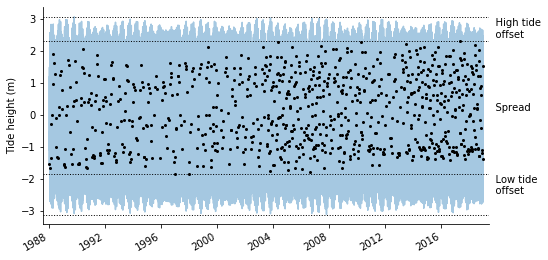

In [90]:
tidal_stats = tidal_eval(ds)

In [91]:
all_timerange, all_tideheights, ds_tides, stats_test = tidal_stats

In [121]:
from scipy import stats

# Extract x (time) and y (distance) values
obs_x = (ds_tides.time.dt.year + 
         ((ds_tides.time.dt.dayofyear - 1) / 365) + 
         ((ds_tides.time.dt.hour - 1) / 24))
obs_y = ds_tides.tide_height.values.astype(np.float)
           
# Compute linear regression
obs_linreg = lin_reg = stats.linregress(x=obs_x, y=obs_y)  

In [150]:
# Extract x (time) and y (distance) values
all_x = (all_timerange.year + 
         ((all_timerange.dayofyear - 1) / 365) +
         ((all_timerange.hour - 1) / 24))
all_y = all_tideheights
time_period = all_x.max() - all_x.min()
           
# Compute linear regression
all_linreg = stats.linregress(x=all_x, y=all_y)

In [152]:
if obs_linreg.pvalue > 0.05:
    print('Observed tides do not increase or decrease significantly over '
          'the time period.')
else:
    obs_slope_desc = 'decrease' if obs_linreg.slope < 0 else 'increase'
    print(f'Observed tides {obs_slope_desc} significantly '
          f'(p={obs_linreg.pvalue:.3f}) over time by '
          f'{obs_linreg.slope:.03f} m per year (i.e. a '
          f'~{time_period * obs_linreg.slope:.2f} m '
          f'{obs_slope_desc} over the {time_period:.1f} year period)')
    
if all_linreg.pvalue > 0.05:
    print('All tides do not increase or decrease significantly over '
          'the time period.')
else:
    all_slope_desc = 'decrease' if all_linreg.slope < 0 else 'increase'
    print(f'All tides {all_slope_desc} significantly '
          f'(p={all_linreg.pvalue:.3f}) over time by '
          f'{all_linreg.slope:.03f} m per year (i.e. a '
          f'~{time_period * all_linreg.slope:.2f} m '
          f'{all_slope_desc} over the {time_period:.1f} year period)')

Observed tides increase significantly (p=0.011) over time by 0.011 m per year (i.e. a ~0.34 m increase over the 31.9 year period)
All tides decrease significantly (p=0.033) over time by -0.001 m per year (i.e. a ~-0.03 m decrease over the 31.9 year period)


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)